In [ ]:
! pip3 install -q kaggle

from google.colab import drive
drive.mount('/content/drive/')

! mkdir ~/.kaggle

! cp /content/drive/MyDrive/kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/breast-histopathology-images

! unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [ ]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [ ]:
from glob import glob
# data = glob('IDC_regular_ps50_idx5/**/*.png', recursive = True)
data_0 = glob('IDC_regular_ps50_idx5/*/0/*.png', recursive = True)
data_1 = glob('IDC_regular_ps50_idx5/*/1/*.png', recursive = True)

In [1]:
img_size = 64
num_channels = 1

In [ ]:
import random

def randomSamples(imageData):
    lst = list()
    while(len(lst) != 25000):
        a = random.choice(imageData)

        if a not in lst:
            lst.append(a)

    return lst

In [ ]:
# import cv2
# import matplotlib.pyplot as plt

# images_original = list()
# labels = list()
# newData = list()

# newData = randomSamples(data)

# for i in newData:
#     if i.endswith('.png'):
#         label = i[-5]
#         img = cv2.imread(i)
#         img_1 = cv2.resize(img, (img_size, img_size))
#         images_original.append(img_1)
#         labels.append(label)

In [7]:
import tensorflow as tf

In [ ]:
# n = 5
# plt.figure(figsize=(10, 5))
# for i in range(n):
#     ax = plt.subplot(1, n, i + 1)
#     plt.title("original")
#     plt.imshow(tf.squeeze(images_original[i]))
#     plt.gray()
# plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt

images = list()
labels = list()
newData = list()

# newData = randomSamples(data)
newData_0 = randomSamples(data_0)
newData_1 = randomSamples(data_1)

for i in newData_0:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2GRAY)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

for i in newData_1:
    if i.endswith('.png'):
        label = i[-5]
        img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2GRAY)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

In [ ]:
x = np.stack(images)

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [ ]:
x = x / 255

In [ ]:
from sklearn.model_selection import train_test_split

train_images, test_images, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2)
train_images, val_images, y_train, y_val = train_test_split(train_images, y_train, random_state = 0, test_size = 0.3)

In [ ]:
train_images.shape, test_images.shape, val_images.shape

((28000, 64, 64), (10000, 64, 64), (12000, 64, 64))

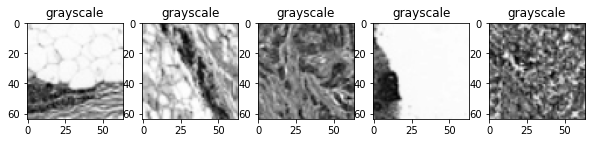

In [ ]:
n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("grayscale")
    plt.imshow(tf.squeeze(test_images[i]))
    plt.gray()
plt.show()

In [ ]:
train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]
val_size = val_images.shape[0]

# Building VAE

Building the encoder

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential, backend
from tensorflow.keras.layers import Lambda, Conv2D, Flatten, Dense, Reshape, Input, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2022-11-22 23:39:12.288359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 23:39:12.597397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 23:39:12.597424: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 23:39:12.643569: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 23:39:14.173381: W tensorflow/stream_executor/platform/de

In [3]:
latent_dim = 5

In [4]:
def sampling(inputs):
    mean, logvar = inputs
    batch = tf.shape(mean)[0]
    dim = tf.shape(mean)[1]
    eps = backend.random_normal(shape = (batch, dim))

    return mean + tf.exp(0.5 * logvar) * eps

Encoder

In [8]:
encoder_input = Input(shape = (img_size, img_size, num_channels), name = "Encoder Input")
conv_1 = Conv2D(filters = 32, kernel_size = 3, strides = 2,
                activation = 'relu', padding = "same",
                name = "Conv_1")(encoder_input)
conv_2 = Conv2D(filters = 64, kernel_size = 3, strides = 2,
                activation = 'relu', padding = "same",
                name = "Conv_2")(conv_1)
flatten_layer = Flatten(name = "Flatten")(conv_2)
dense_layer = Dense(latent_dim + latent_dim, activation = 'relu',
                    name = "Dense")(flatten_layer)
mean = Dense(latent_dim, name = "Mean")(dense_layer)
logvar = Dense(latent_dim, name = "Log_Variance")(dense_layer)
z = Lambda(sampling, name = "Z")([mean, logvar])
encoder = Model(encoder_input, z, name = "Encoder")
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder Input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 Conv_1 (Conv2D)                (None, 32, 32, 32)   320         ['Encoder Input[0][0]']          
                                                                                                  
 Conv_2 (Conv2D)                (None, 16, 16, 64)   18496       ['Conv_1[0][0]']                 
                                                                                                  
 Flatten (Flatten)              (None, 16384)        0           ['Conv_2[0][0]']                 
                                                                                            

Decoder

In [9]:
decoder_input = Input(shape = (latent_dim), name = "Decoder Input")
dense_layer = Dense(units = 16 * 16 * 64, activation = tf.nn.relu, name = "Dense")(decoder_input)
reshape_layer = Reshape(target_shape = (16, 16, 64), name = "Reshape")(dense_layer)
conv_transpose_1 = Conv2DTranspose(filters = 64, kernel_size = 3, 
                            strides = 2, padding = "same",
                            activation = "relu", 
                            name = "Conv_Transpose_1")(reshape_layer)
conv_transpose_2 = Conv2DTranspose(filters = 32, kernel_size = 3, 
                            strides = 2, padding = "same",
                            activation = "relu", 
                            name = "Conv_Transpose_2")(conv_transpose_1)
decoder_output = Conv2DTranspose(filters = 1, kernel_size = 3, 
                            strides = 1, padding = "same",
                            activation = "sigmoid", 
                            name = "Conv_Transpose_3")(conv_transpose_2)
decoder = Model(decoder_input, decoder_output, name = "Decoder")
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder Input (InputLayer)  [(None, 5)]               0         
                                                                 
 Dense (Dense)               (None, 16384)             98304     
                                                                 
 Reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 Conv_Transpose_1 (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 Conv_Transpose_2 (Conv2DTra  (None, 64, 64, 32)       18464     
 nspose)                                                         
                                                                 
 Conv_Transpose_3 (Conv2DTra  (None, 64, 64, 1)        289 

In [10]:
import visualkeras

In [15]:
visualkeras.layered_view(encoder, legend = True, to_file="encoder.png").show()

In [16]:
visualkeras.layered_view(decoder, legend = True, to_file="decoder.png").show()

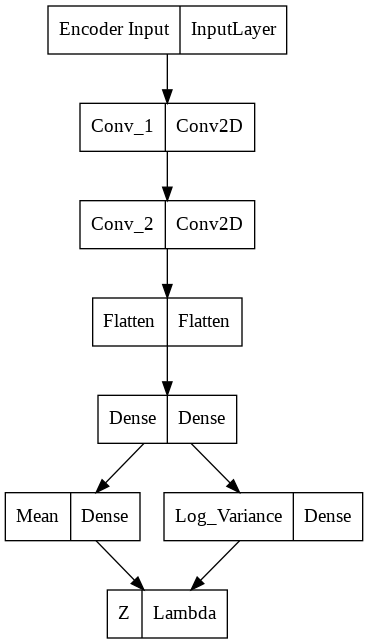

In [ ]:
plot_model(encoder)

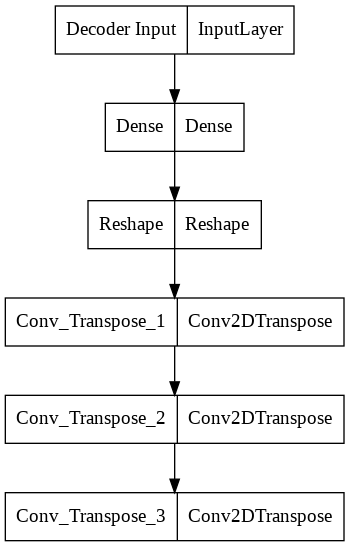

In [ ]:
plot_model(decoder)

Variational Autoencoder

In [ ]:
vae_input = Input(shape = (img_size, img_size, num_channels), name = 'VAE_input')

vae_encoder_output = encoder(vae_input)

vae_decoder_output = decoder(vae_encoder_output)

vae = Model(vae_input, vae_decoder_output, name = 'VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 64, 64, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 5)                 182776    
                                                                 
 Decoder (Functional)        (None, 64, 64, 1)         153985    
                                                                 
Total params: 336,761
Trainable params: 336,761
Non-trainable params: 0
_________________________________________________________________


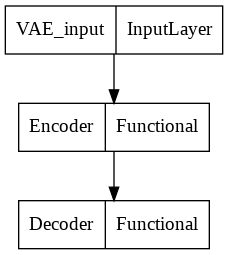

In [ ]:
plot_model(vae)

In [ ]:
def loss_func(mean, log_var):

    def vae_reconstruction_loss(y_true, y_predict):
        return tf.math.reduce_mean(
            tf.math.reduce_sum(
                keras.losses.binary_crossentropy(y_true, y_predict, axis = (1, 2))
            )
        )
    
    def vae_kl_loss(mean, log_var):
        kl_loss = -0.5 * (1 + log_var - tf.math.square(mean) - tf.math.exp(log_var))
        return tf.math.reduce_mean(tf.math.reduce_sum(kl_loss, axis = 1))

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
vae.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss_func(mean, logvar))

In [ ]:
train_images = np.reshape(train_images, newshape=(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)) 
test_images = np.reshape(test_images, newshape=(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1))
val_images = np.reshape(val_images, newshape=(val_images.shape[0], val_images.shape[1], val_images.shape[2], 1))

In [ ]:
with tf.device("/gpu:0"):
    history = vae.fit(train_images, train_images, epochs = 25, 
                      batch_size = 32, shuffle = True, 
                      validation_data = (val_images, val_images))

Epoch 1/25
875/875 [==============================] - 21s 13ms/step - loss: 41.7435 - val_loss: 41.6276
Epoch 2/25
875/875 [==============================] - 11s 12ms/step - loss: 41.5491 - val_loss: 41.5673
Epoch 3/25
875/875 [==============================] - 11s 13ms/step - loss: 41.5184 - val_loss: 41.5645
Epoch 4/25
875/875 [==============================] - 11s 13ms/step - loss: 41.5166 - val_loss: 41.5592
Epoch 5/25
875/875 [==============================] - 10s 11ms/step - loss: 41.5153 - val_loss: 41.5597
Epoch 6/25
875/875 [==============================] - 10s 11ms/step - loss: 41.5146 - val_loss: 41.5593
Epoch 7/25
875/875 [==============================] - 10s 12ms/step - loss: 41.5135 - val_loss: 41.5568
Epoch 8/25
875/875 [==============================] - 11s 12ms/step - loss: 41.5127 - val_loss: 41.5563
Epoch 9/25
875/875 [==============================] - 10s 11ms/step - loss: 41.5046 - val_loss: 41.5349
Epoch 10/25
875/875 [==============================] - 11s 13ms/

In [ ]:
# Reduce learing rate if the learning seems to have become constant

rlronp_2 = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    mode = 'min',
    min_lr = 1e-10,
    patience = 2,
    verbose = 1
    )

estop_2 = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 3, 
    verbose = 1,
    restore_best_weights = True
)

with tf.device("/gpu:0"):
    history_with_callbacks_2 = vae.fit(
        train_images, train_images,
        epochs = 25,
        validation_data = (val_images, val_images),
        callbacks = [rlronp_2, estop_2]
    )

Epoch 1/25
875/875 [==============================] - 10s 11ms/step - loss: 41.4782 - val_loss: 41.5295 - lr: 0.0010
Epoch 2/25
875/875 [==============================] - 11s 13ms/step - loss: 41.4781 - val_loss: 41.5270 - lr: 0.0010
Epoch 3/25
875/875 [==============================] - 11s 12ms/step - loss: 41.4781 - val_loss: 41.5271 - lr: 0.0010
Epoch 4/25
872/875 [============================>.] - ETA: 0s - loss: 41.4754
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
875/875 [==============================] - 10s 11ms/step - loss: 41.4772 - val_loss: 41.5278 - lr: 0.0010
Epoch 5/25
875/875 [==============================] - 11s 12ms/step - loss: 41.4730 - val_loss: 41.5254 - lr: 2.0000e-04
Epoch 6/25
875/875 [==============================] - 9s 11ms/step - loss: 41.4723 - val_loss: 41.5256 - lr: 2.0000e-04
Epoch 7/25
872/875 [============================>.] - ETA: 0s - loss: 41.4728
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.00000018998980

In [ ]:
encoder.save("Encoder_vae.h5") 
decoder.save("Decoder_vae.h5") 
vae.save("VAE_model.h5")

In [ ]:
# Loading the model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Local_Backup/Codes_WSL/drive_before_VAE.h5')

# saved_encoder = load_model('/content/drive/MyDrive/Local_Backup/Codes_WSL/Encoder_vae.h5')
# saved_decoder = load_model('/content/drive/MyDrive/Local_Backup/Codes_WSL/Decoder_vae.h5')
# saved_vae = load_model('/content/drive/MyDrive/Local_Backup/Codes_WSL/VAE_model.h5')

In [ ]:
encoded_train_data = encoder.predict(train_images)
decoded_train_data = decoder.predict(encoded_train_data)

encoded_val_data = encoder.predict(val_images)
decoded_val_data = decoder.predict(encoded_val_data)

encoded_test_data = encoder.predict(test_images)
decoded_test_data = decoder.predict(encoded_test_data)

vae_train_output = vae.predict(train_images)
vae_val_output = vae.predict(val_images)
vae_test_output = vae.predict(test_images)

313/313 [==============================] - 1s 4ms/step


In [ ]:
print('decoded_train_data:', decoded_train_data.shape)
print('decoded_test_data:', decoded_test_data.shape)
print("decoded_val_data:", decoded_val_data.shape)
print('vae_train_output:', vae_train_output.shape)
print('vae_val_output:', vae_val_output.shape)
print('vae_test_output:', vae_test_output.shape)

decoded_train_data: (28000, 64, 64, 1)
decoded_test_data: (10000, 64, 64, 1)
decoded_val_data: (12000, 64, 64, 1)
vae_train_output: (28000, 64, 64, 1)
vae_val_output: (12000, 64, 64, 1)
vae_test_output: (10000, 64, 64, 1)


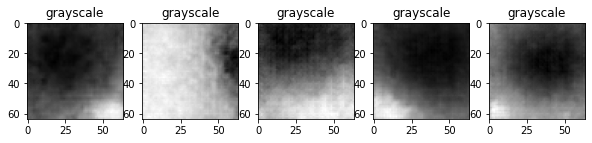

In [ ]:
n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("grayscale")
    plt.imshow(tf.squeeze(vae_test_output[i]))
    plt.gray()
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

m = [
    'acc', 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall(), 
    tf.keras.metrics.AUC()
    ]

# opt = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad =  False)
# opt = Adam(leaerning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = m)

In [ ]:
# Decoded Training and Testing data evaluation metrics

train_loss, train_accuracy, train_precision, train_recall, train_auc = model.evaluate(decoded_train_data, y_train)
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(decoded_val_data, y_val)
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(decoded_test_data, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.9269 - acc: 0.5002 - precision_1: 0.5002 - recall_1: 0.5002 - auc_1: 0.5608


In [ ]:
# VAE Training and Testing data evaluation metrics

loss_train, accuracy_train, precision_train, recall_train, auc_train = model.evaluate(vae_train_output, y_train)
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(vae_val_output, y_val)
loss_test, accuracy_test, precision_test, recall_test, auc_test = model.evaluate(vae_test_output, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.9269 - acc: 0.5002 - precision_1: 0.5002 - recall_1: 0.5002 - auc_1: 0.5607


In [ ]:
with tf.device("/gpu:0"):
    new_history = model.fit(vae_train_output, y_train, epochs = 25, 
                            batch_size = 32, 
                            validation_data = (vae_val_output, y_val))

Epoch 1/25
875/875 [==============================] - 10s 10ms/step - loss: 0.6192 - acc: 0.6779 - precision_1: 0.6836 - recall_1: 0.6639 - auc_1: 0.7219 - val_loss: 0.5733 - val_acc: 0.7108 - val_precision_1: 0.7141 - val_recall_1: 0.7057 - val_auc_1: 0.7735
Epoch 2/25
875/875 [==============================] - 7s 8ms/step - loss: 0.5689 - acc: 0.7177 - precision_1: 0.7205 - recall_1: 0.7125 - auc_1: 0.7764 - val_loss: 0.5739 - val_acc: 0.7155 - val_precision_1: 0.7163 - val_recall_1: 0.7118 - val_auc_1: 0.7710
Epoch 3/25
875/875 [==============================] - 7s 8ms/step - loss: 0.5668 - acc: 0.7197 - precision_1: 0.7214 - recall_1: 0.7139 - auc_1: 0.7785 - val_loss: 0.5695 - val_acc: 0.7194 - val_precision_1: 0.7203 - val_recall_1: 0.7155 - val_auc_1: 0.7760
Epoch 4/25
875/875 [==============================] - 8s 9ms/step - loss: 0.5650 - acc: 0.7218 - precision_1: 0.7241 - recall_1: 0.7171 - auc_1: 0.7804 - val_loss: 0.5600 - val_acc: 0.7283 - val_precision_1: 0.7296 - val_rec

In [ ]:
with tf.device("/gpu:0"):
    history_with_callbacks = model.fit(
        vae_train_output, y_train,
        epochs = 25,
        validation_data = (vae_val_output, y_val),
        callbacks = [rlronp_2, estop_2]
    )

Epoch 1/25
875/875 [==============================] - 7s 8ms/step - loss: 0.5576 - acc: 0.7250 - precision_1: 0.7285 - recall_1: 0.7189 - auc_1: 0.7876 - val_loss: 0.5538 - val_acc: 0.7315 - val_precision_1: 0.7341 - val_recall_1: 0.7247 - val_auc_1: 0.7929 - lr: 1.0000e-04
Epoch 2/25
875/875 [==============================] - 7s 8ms/step - loss: 0.5584 - acc: 0.7244 - precision_1: 0.7276 - recall_1: 0.7166 - auc_1: 0.7868 - val_loss: 0.5519 - val_acc: 0.7315 - val_precision_1: 0.7355 - val_recall_1: 0.7260 - val_auc_1: 0.7938 - lr: 1.0000e-04
Epoch 3/25
875/875 [==============================] - 7s 8ms/step - loss: 0.5579 - acc: 0.7241 - precision_1: 0.7271 - recall_1: 0.7164 - auc_1: 0.7873 - val_loss: 0.5528 - val_acc: 0.7301 - val_precision_1: 0.7336 - val_recall_1: 0.7253 - val_auc_1: 0.7956 - lr: 1.0000e-04
Epoch 4/25
875/875 [==============================] - ETA: 0s - loss: 0.5572 - acc: 0.7265 - precision_1: 0.7306 - recall_1: 0.7191 - auc_1: 0.7879
Epoch 4: ReduceLROnPlateau 

In [ ]:
# VAE Training and Testing data evaluation metrics

loss_train, accuracy_train, precision_train, recall_train, auc_train = model.evaluate(vae_train_output, y_train)
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(vae_val_output, y_val)
loss_test, accuracy_test, precision_test, recall_test, auc_test = model.evaluate(vae_test_output, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.5488 - acc: 0.7365 - precision_1: 0.7397 - recall_1: 0.7305 - auc_1: 0.7966


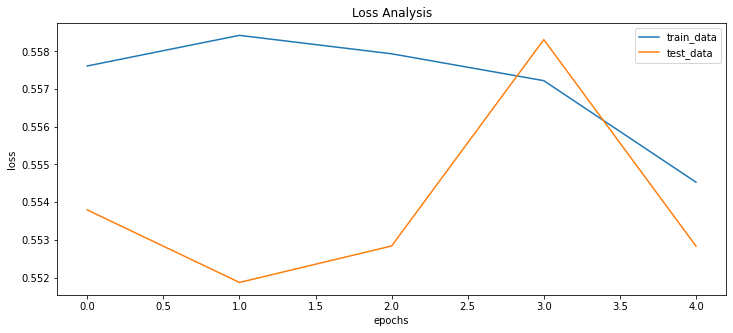

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history_with_callbacks.history['loss'])
plt.plot(history_with_callbacks.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

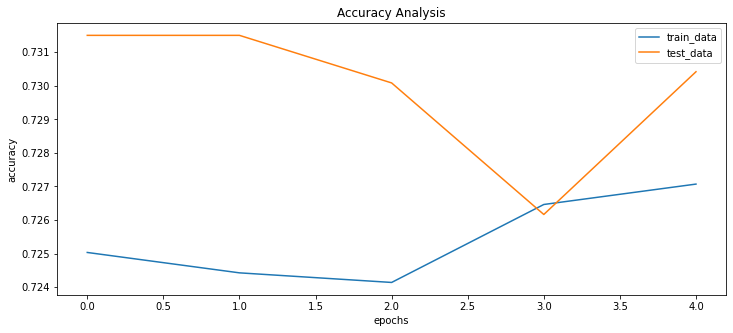

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history_with_callbacks.history['acc'])
plt.plot(history_with_callbacks.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()

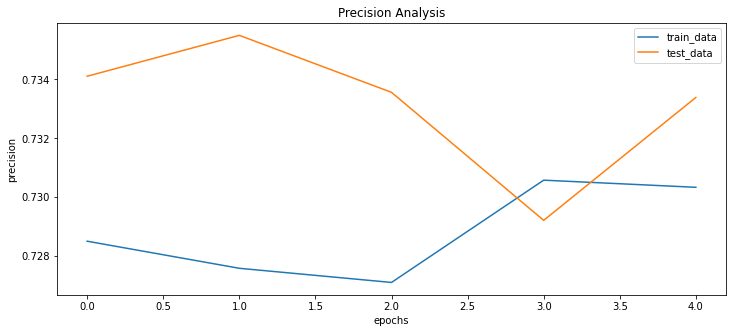

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history_with_callbacks.history['precision_1'])
plt.plot(history_with_callbacks.history['val_precision_1'])
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend(['train_data', 'test_data'])
plt.title('Precision Analysis')
plt.show()

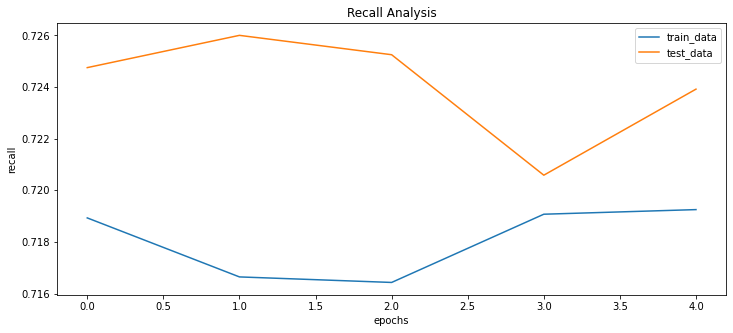

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history_with_callbacks.history['recall_1'])
plt.plot(history_with_callbacks.history['val_recall_1'])
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend(['train_data', 'test_data'])
plt.title('Recall Analysis')
plt.show()

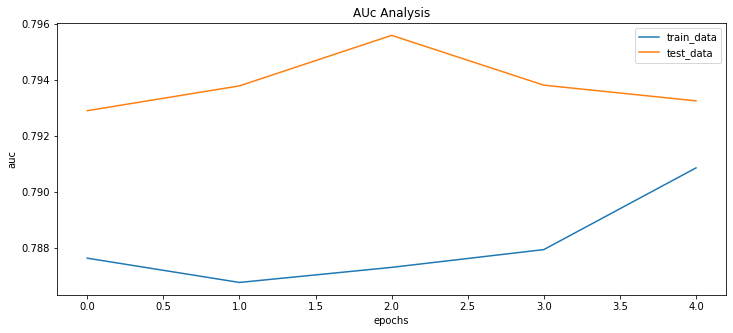

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history_with_callbacks.history['auc_1'])
plt.plot(history_with_callbacks.history['val_auc_1'])
plt.xlabel('epochs')
plt.ylabel('auc')
plt.legend(['train_data', 'test_data'])
plt.title('AUc Analysis')
plt.show()

# Statistical Analysis

In [ ]:
y_pred = np.argmax(model.predict(vae_test_output), axis = 1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
cm = confusion_matrix(y_true,y_pred)
print(cm)

[[3580 1422]
 [1213 3785]]


In [ ]:
target_names=['IDC Positive (1)', 'IDC Negative (0)']
print(classification_report(y_true, y_pred, target_names = target_names, digits=2))

                  precision    recall  f1-score   support

IDC Positive (1)       0.75      0.72      0.73      5002
IDC Negative (0)       0.73      0.76      0.74      4998

        accuracy                           0.74     10000
       macro avg       0.74      0.74      0.74     10000
    weighted avg       0.74      0.74      0.74     10000



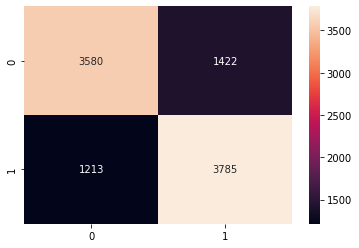

In [ ]:
import seaborn as sns
f = sns.heatmap(cm, annot=True, fmt='d')  #confusion matrix plot

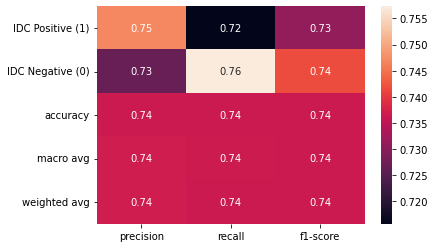

In [ ]:
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, target_names = target_names, output_dict = True)).iloc[:-1, :].T, annot=True)  

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, roc_auc_score, plot_confusion_matrix, classification_report

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred, average = 'weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred, average = 'weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred, average = 'weighted')
print('F1 score: %f' % f1)

Accuracy: 0.736500
Precision: 0.736918
Recall: 0.736500
F1 score: 0.736387


In [ ]:
   # kappa
kappa = cohen_kappa_score(y_true, y_pred)
print('Cohens kappa: %f' % kappa)
    # ROC AUC
auc = roc_auc_score(y_test, model.predict(vae_test_output))
print('ROC AUC: %f' % auc)

Cohens kappa: 0.473009
313/313 [==============================] - 1s 2ms/step
ROC AUC: 0.796977


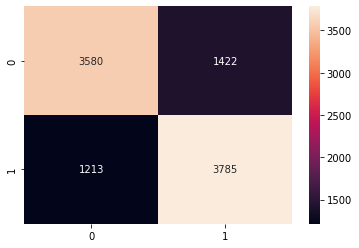

In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_true, y_pred)
f = sns.heatmap(cnf_matrix, annot=True, fmt='d')

In [ ]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [ ]:
print(f'FP: {FP}' )
print(f'FN: {FN}' )
print(f'TP: {TP}' )
print(f'TN: {TN}' )

FP: [1213. 1422.]
FN: [1422. 1213.]
TP: [3580. 3785.]
TN: [3785. 3580.]


In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
my_formatted_TPR = [ '%.2f' % elem for elem in TPR ]
print(f'Sensitivity: {my_formatted_TPR}') 

# Specificity or true negative rate
TNR = TN/(TN+FP) 
my_formatted_TNR = [ '%.2f' % elem for elem in TNR ]
print(f'Specificity: {my_formatted_TNR}') 

# Precision or positive predictive value
PPV = TP/(TP+FP)
my_formatted_PPV = [ '%.2f' % elem for elem in PPV ]
print(f'Precision: {my_formatted_PPV}') 
# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
my_formatted_ACC = [ '%.2f' % elem for elem in ACC ]
print(f'accuracy: {my_formatted_ACC}')

F1 = 2 * (PPV * TPR) / (PPV + TPR)
my_formatted_F1 = [ '%.2f' % elem for elem in F1 ]
print(f'F1 Score: {my_formatted_F1}') 

num_classes = 2

print("-"*40)
sens=TPR.sum()/num_classes
spec=TNR.sum()/num_classes
f1=F1.sum()/num_classes
print(f'Sensitivity/Recall: {round(sens,2)}'  )
print(f'Specificity: {round(spec,2)}' )
print(f'F1 score: {round(f1,2)}' )

Sensitivity: ['0.72', '0.76']
Specificity: ['0.76', '0.72']
Precision: ['0.75', '0.73']
accuracy: ['0.74', '0.74']
F1 Score: ['0.73', '0.74']
----------------------------------------
Sensitivity/Recall: 0.74
Specificity: 0.74
F1 score: 0.74
